In [215]:
import pandas as pd
from pandas import Series, DataFrame

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [217]:
train = pd.read_csv("/home/akki/Downloads/Titanic Dataset/train.csv")
test = pd.read_csv("/home/akki/Downloads/Titanic Dataset/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [218]:
train.info()
print('----------------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [219]:
# Drop Unnecessary columns.
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


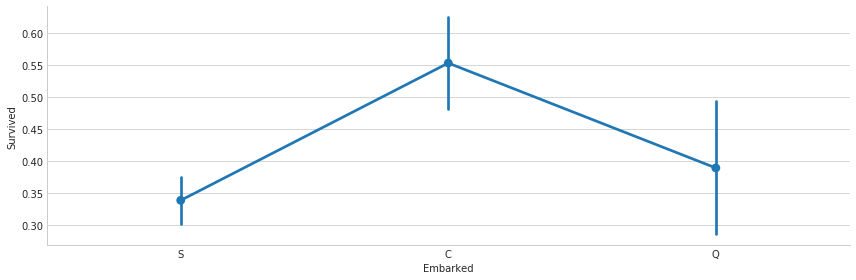

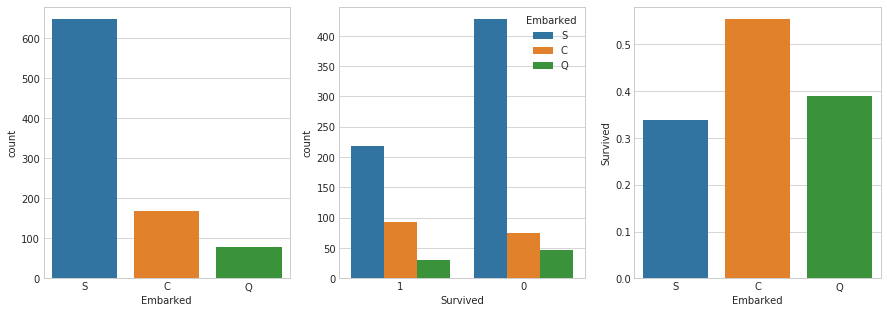

In [220]:
# Embarked

# In train dataset, fill two missing values with the most occurred value, which is "S".
train["Embarked"] = train["Embarked"].fillna("S")

#plotting
sns.factorplot('Embarked', 'Survived', data=train, size=4, aspect=3)
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15,5))
sns.countplot(x='Embarked', data=train, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean()
print(embark_perc)
sns.barplot(x="Embarked", y="Survived", data=embark_perc, order=['S', 'C', 'Q'], ax=axis3)

# Either to consider Embarked column in predictions, and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_train = pd.get_dummies(train['Embarked'])
embark_dummies_train.drop(["S"], axis=1, inplace=True)

embark_dummies_test = pd.get_dummies(test['Embarked'])
embark_dummies_test.drop(["S"], axis=1, inplace=True)

train = train.join(embark_dummies_train, lsuffix='_left', rsuffix='_right')
test = test.join(embark_dumies_test, lsuffix='_left', rsuffix='_right')

train.drop(['Embarked'], axis=1, inplace=True)
test.drop(['Embarked'], axis=1, inplace=True)

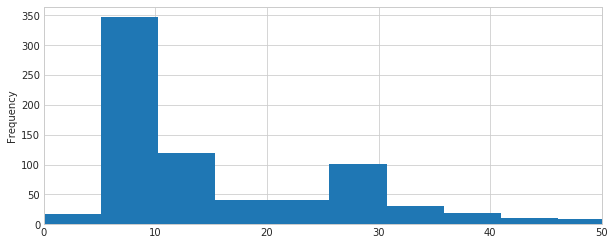

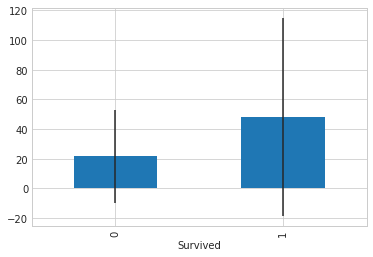

In [221]:
# Fare
test["Fare"].fillna(test["Fare"].median(), inplace=True)

# Convert from float to int
train["Fare"] = train["Fare"].astype(int)
test["Fare"] = test["Fare"].astype(int)

# get fare for survived and non survived passengers.
fare_not_survived = train["Fare"][train["Survived"] == 0]
fare_survived = train["Fare"][train["Survived"] == 1]

# get average and std for fare of survived and non survived passengers.
average_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = DataFrame([fare_not_survived.std(), fare_survived.std()])

#plot
train["Fare"].plot(kind='hist', figsize=(10,4), bins=100, xlim=(0,50))
average_fare.index.names = std_fare.index.names = ["Survived"]
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


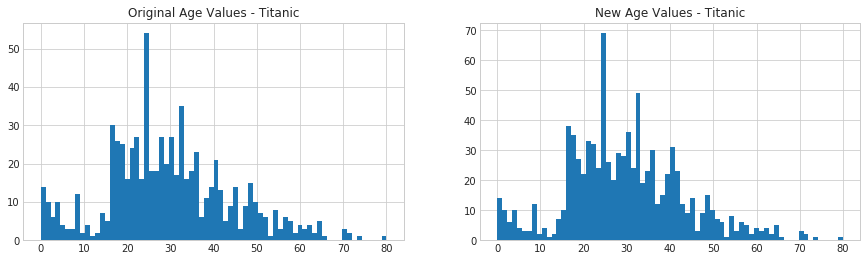

In [222]:
# Age
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
axis1.set_title('Original Age Values - Titanic')
axis2.set_title('New Age Values - Titanic')

# get average, std and number of NaN values in train
average_age_train = train['Age'].mean()
std_age_train = train['Age'].std()
count_nan_age_train = train['Age'].isnull().sum()

#get average, std and number of NaN values in test
average_age_test = test['Age'].mean()
std_age_test = test['Age'].std()
count_nan_age_test = test['Age'].isnull().sum()

# generate random numbers between (mean-std) and (mean+std)
rand_1 = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size=count_nan_age_train)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size=count_nan_age_test)

# plot original age values
# NOTE: drop all null values and convert it to int.
train['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill Nan values in Age column with random values and generated
train['Age'][np.isnan(train['Age'])] = rand_1
test['Age'][np.isnan(test['Age'])] = rand_2

# convert from float to int
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

# pot new age values
train['Age'].hist(bins=70, ax=axis2)

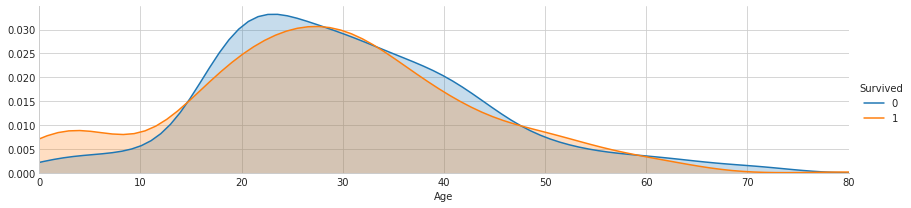

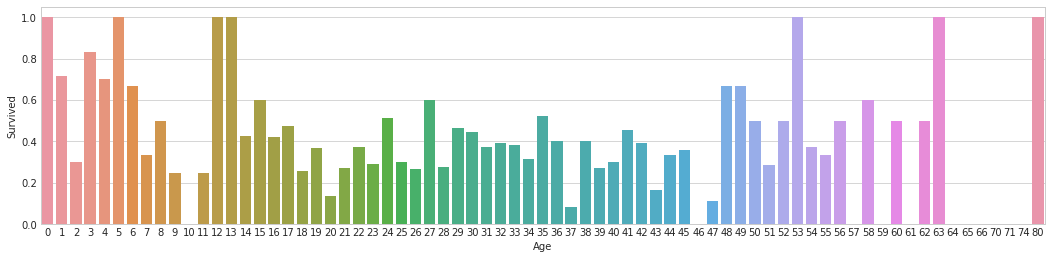

In [223]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
average_age = train[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [224]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

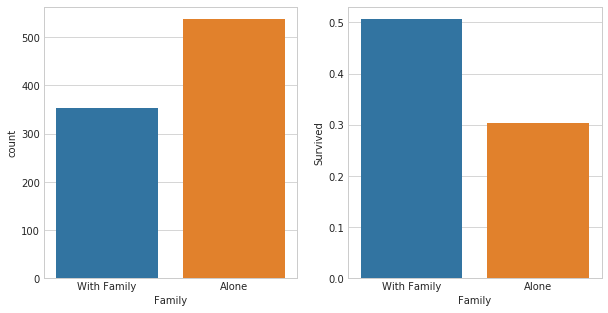

In [225]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
train['Family'] = train['Parch'] + train['SibSp']
train['Family'].loc[train['Family'] > 0] = 1
train['Family'].loc[train['Family'] == 0] = 0

test['Family'] = test['Parch'] + test['SibSp']
test['Family'].loc[test['Family'] > 0] = 1
test['Family'].loc[test['Family'] == 0] = 0

# drop Parch and Sibsp
train = train.drop(['SibSp', 'Parch'], axis=1)
test = test.drop(['SibSp', 'Parch'], axis=1)
# plot
fig, (axis1, axis2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
sns.countplot(x='Family', data=train, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)
axis1.set_xticklabels(['With Family', 'Alone'], rotation=0)

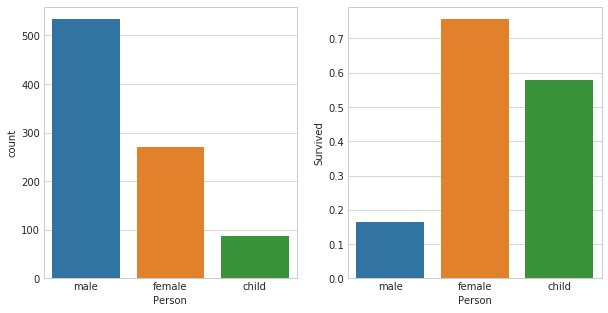

In [226]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age<16 else sex

train['Person'] = train[['Age', 'Sex']].apply(get_person, axis=1)
test['Person'] = test[['Age', 'Sex']].apply(get_person, axis=1)

# No need to use Sex column since we created Person column
train.drop(['Sex'], axis=1, inplace=True)
test.drop(['Sex'], axis=1, inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_train = pd.get_dummies(train['Person'])
person_dummies_train.columns = ['Child', 'Female', 'Male']
person_dummies_train.drop(['Male'], axis=1, inplace=True)

person_dummies_test = pd.get_dummies(test['Person'])
person_dummies_test.columns = ['Child', 'Female', 'Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train = train.join(person_dummies_train, lsuffix='_left', rsuffix='_right')
test = test.join(person_dummies_test, lsuffix='_left', rsuffix='_right')

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10,5))

sns.countplot(x='Person', data=train, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = train[['Person', 'Survived']].groupby(['Person'], as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male', 'female', 'child'])

train.drop(['Person'], axis=1, inplace=True)
test.drop(['Person'], axis=1, inplace=True)

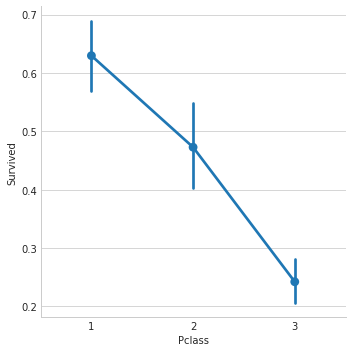

In [230]:
# Pclass

sns.factorplot('Pclass', 'Survived', order=[1,2,3], data=train, size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
p_class_dummies_train = pd.get_dummies(train['Pclass'])
p_class_dummies_train.columns = ['Class_1', 'Class_2', 'Class_3']
p_class_dummies_train.drop(['Class_3'], axis=1, inplace=True)

p_class_dummies_test = pd.get_dummies(test['Pclass'])
p_class_dummies_test.columns = ['Class_1', 'Class_2', 'Class_3']
p_class_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train.drop(['Pclass'], axis=1, inplace=True)
test.drop(['Pclass'], axis=1, inplace=True)

train = train.join(p_class_dummies_train)
test = test.join(p_class_dummies_test)

In [234]:
# define training and testing sets

X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop('PassengerId', axis=1).copy()

# Logistic Regression

In [235]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg.score(X_train, y_train)

0.81032547699214363

# Support Vector Machines

In [237]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
svc.score(X_train, y_train)

0.86531986531986527

# Random Forests


In [240]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)b
svc.score(X_train, y_train)

0.86531986531986527

# KNN with n=3

In [242]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X_train, y_train)

0.83838383838383834

# Gaussian Naive Bayes

In [244]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
gaussian.score(X_train, y_train)

0.75982042648709314

In [245]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.029692
1,Fare,0.000948
2,C,0.593054
3,Q,0.240886
4,Family,-0.246098
5,Child,1.688684
6,Female,2.778570
7,Class_1,2.081748
8,Class_2,1.148674


In [257]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_pred
})
submission.to_csv('/home/akki/Downloads/Titanic Dataset/output.csv', index=False)

In [258]:
# Test File
df = pd.read_csv("/home/akki/Downloads/Titanic Dataset/output.csv")
df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
